In [19]:
import numpy as np
from scipy.integrate import solve_ivp
from numba import njit
from scipy.linalg import solve_triangular
from functions.kr_functions import log_points

In [20]:
# constants #

ki = 1.2e-06 # 1/s
kp = 500 # L/mol*s
ktc = 0.0 #6e06 # L/mol*s
ktd = 6e06 # L/mol*s
kfm = 9.1e-02 # L/mol*s
kfp = 0.5 # L/mol*s
kpp = 0.05 # L/mol*s
f = 1.0
M0 = 8.4 # mol/L
I0 = 0.002 #mol/L

In [21]:
@njit
def lambda_0(I): # moment zero for radicals
    return np.sqrt((2 * f * ki * I) / (ktd + ktc))

@njit
def lambda_1(M, L0, mu_1, mu_2): # momento one for radicals
    num = kp * M * L0 + kfp * L0 * mu_2
    denm = kfm * M + (ktd + ktc) * L0 + kfp * mu_1
    
    return num / denm

In [22]:
n = log_points(100, 2, 1_000_000)
print(n.shape)

# Crear un array con 400 elementos para b de propagación
b_p = 1.0 / np.diff(n)
b_p = np.append(b_p, b_p[-1])


(100,)


#### Solo con terminación por desproporción

In [23]:
# Función principal
def balances_KR(t, y):
    # Descomposición del vector de estados
    I = y[0]
    M = y[1]
    mu_0 = y[2]
    mu_1 = y[3]
    mu_2 = y[4]
    Nrd = y[5:105]  # Radicales
    Npd = y[105:205]  # Polímeros

    # Cálculo de momentos de los radicales
    L0 = lambda_0(I)
    L1 = lambda_1(M, L0, mu_1, mu_2)

    # Ecuaciones diferenciales
    dIdt = -ki * I
    dMdt = -(kp + kfm) * M * L0
    dmu_0dt = kfm * M * L0 + (0.5 * ktc + ktd) * L0**2
    dmu_1dt = kp * M * L0
    dmu_2dt = kp * M * (L0 + 2 * L1) + ktc * L1**2

    # Ecuaciones para los radicales y polímeros
    dNrdt = np.zeros_like(Nrd)
    dNpdt = np.zeros_like(Npd)

    # 
    for idx in range(len(Nrd)):
        if idx == 0:
            dNrdt[idx] = (- (kfm * M + ktd * L0 + kfp * mu_1) * Nrd[idx]
                          - kp * M * (b_p[idx] * Nrd[idx])
                          + kfp * L0 * n[idx] * Npd[idx]
                          + kfm * M * L0 + 2 * f * ki * I)
        else:
            dNrdt[idx] = (- (kfm * M + ktd * L0 + kfp * mu_1) * Nrd[idx]
                          + kp * M * (b_p[idx-1] * Nrd[idx-1] - b_p[idx] * Nrd[idx])
                          + kfp * L0 * n[idx] * Npd[idx])

    # Para los polimeros (EDO)
    for idx in range(len(Npd)):
        dNpdt[idx] = (- kfp * L0 * n[idx] * Npd[idx]
                      + (kfm * M + ktd * L0 + kfp * mu_1) * Nrd[idx])

    # Concatenación de derivadas
    return np.concatenate(([dIdt, dMdt, dmu_0dt, dmu_1dt, dmu_2dt], dNrdt, dNpdt))

In [24]:
y0 = np.zeros(205)
y0[0] = I0
y0[1] = M0

time = [0, 35000]
t_get = [100, 1000, 3500, 10000, 15000, 40000, 60000, 71100, 90000]

In [25]:
sol = solve_ivp(
      balances_KR,
      time, 
      y0, 
      #t_eval=t_get,
      method='LSODA',
      rtol=1e-07,
      atol=1e-10
      )

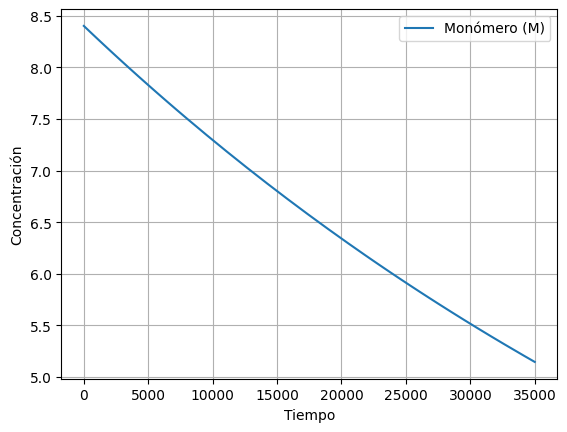

In [26]:
# Visualización
import matplotlib.pyplot as plt

#plt.plot(sol.t, sol.y[0], label="Iniciador (I)")
plt.plot(sol.t, sol.y[1], label="Monómero (M)")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Concentración")
plt.grid()
plt.show()

In [27]:
(8.4-3.36)/8.4

0.6000000000000001

In [28]:
sol.t.shape

(123,)

8.399999936361695

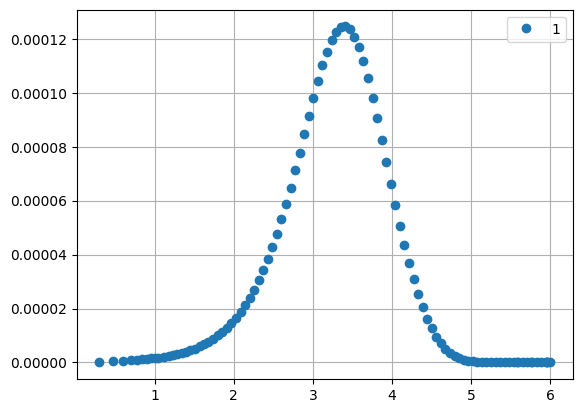

In [31]:
nlog = np.log10(n)
pn1 = sol.y[105:205, 100] / (1/b_p)

pn1n = np.multiply(pn1, n)

plt.plot(nlog, pn1n, 'o', label='1')
plt.grid()
plt.legend()

sol.y[1][7]


In [32]:
y0 = np.zeros(205)
y0[0] = I0
y0[1] = M0

time = [0, 90000]
t_get = [100, 1000, 3500, 10000, 15000, 40000, 60000, 71100, 90000]

sol = solve_ivp(
      balances_KR,
      time, 
      y0, 
      t_eval=t_get,
      method='LSODA',
      rtol=1e-07,
      atol=1e-10
      )

3.1383348489846514

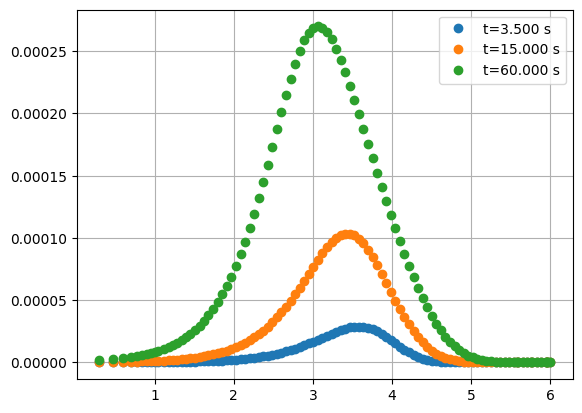

In [33]:
nlog = np.log10(n)
pn1 = sol.y[105:205, 2] / (1/b_p)
pn2 = sol.y[105:205, 4] / (1/b_p)
pn3 = sol.y[105:205, 6] / (1/b_p)

pn1n = np.multiply(pn1, n)
pn2n = np.multiply(pn2, n)
pn3n = np.multiply(pn3, n)

plt.plot(nlog, pn1n, 'o', label='t=3.500 s')
plt.plot(nlog, pn2n, 'o', label='t=15.000 s')
plt.plot(nlog, pn3n, 'o', label='t=60.000 s')
#plt.plot(nlog, pn2, label='2')
#plt.plot(nlog, pn3, label='3')
plt.grid()
plt.legend()

sol.y[1][7]